In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.figsize'] = (12,6)

In [3]:
weather_data = pd.read_csv('~/Spiced/logistic-lemongrass-student-code/week_05/ECA_blended_custom/weather_data.txt', sep =',' , skiprows = 19)


In [4]:
df = pd.DataFrame(weather_data)
df.columns=df.columns.map(str.strip)
df.drop("SOUID", axis=1, inplace=True)

df.head()


,DATE,TG,Q_TG
0,18760101,22,0
1,18760102,25,0
2,18760103,3,0
3,18760104,-58,0
4,18760105,-98,0


In [5]:
df.columns

Index(['DATE', 'TG', 'Q_TG'], dtype='object')

In [6]:
df.rename(columns = {'DATE':'date', 'TG':'tg', 'Q_TG':'qtg'}, inplace=True)
df["date"] = pd.to_datetime(df["date"], format='%Y%m%d')

df['year'] = df["date"].dt.year
df['month'] = df["date"].dt.month
df['week'] = df["date"].dt.week
df['day'] = df["date"].dt.day

df.set_index("date", inplace=True)
df.head()


,tg,qtg,year,month,week,day
date,,,,,,
1876-01-01,22,0,1876,1,52,1
1876-01-02,25,0,1876,1,52,2
1876-01-03,3,0,1876,1,1,3
1876-01-04,-58,0,1876,1,1,4
1876-01-05,-98,0,1876,1,1,5


In [7]:
df.shape


(52777, 6)

In [8]:
assert all(df.loc[df['qtg']==9] == df['1945-04-25':'1945-11-05'])

In [9]:
new_vals = (df['1946-04-25':'1946-11-05']['tg'].values + df['1944-04-25':'1944-11-05']['tg'].values) / 2

In [10]:
new_index = df['1945-04-25':'1945-11-05'].index
new_index

DatetimeIndex(['1945-04-25', '1945-04-26', '1945-04-27', '1945-04-28',
               '1945-04-29', '1945-04-30', '1945-05-01', '1945-05-02',
               '1945-05-03', '1945-05-04',
               ...
               '1945-10-27', '1945-10-28', '1945-10-29', '1945-10-30',
               '1945-10-31', '1945-11-01', '1945-11-02', '1945-11-03',
               '1945-11-04', '1945-11-05'],
              dtype='datetime64[ns]', name='date', length=195, freq=None)

In [11]:
s_1945_new = pd.Series(new_vals, index=new_index)
s_1945_new

date
1945-04-25    115.0
1945-04-26    134.0
1945-04-27    123.0
1945-04-28    111.5
1945-04-29    101.0
              ...  
1945-11-01     54.0
1945-11-02     56.0
1945-11-03     62.5
1945-11-04     71.0
1945-11-05     77.5
Length: 195, dtype: float64

In [12]:
df['tgnew'] = df['tg'].copy()

df.loc['1945-04-25':'1945-11-05', 'tgnew'] = s_1945_new

df['1945-04-23':'1945-04-27']

,tg,qtg,year,month,week,day,tgnew
date,,,,,,,
1945-04-23,61,0,1945,4,17,23,61.0
1945-04-24,80,0,1945,4,17,24,80.0
1945-04-25,-9999,9,1945,4,17,25,115.0
1945-04-26,-9999,9,1945,4,17,26,134.0
1945-04-27,-9999,9,1945,4,17,27,123.0


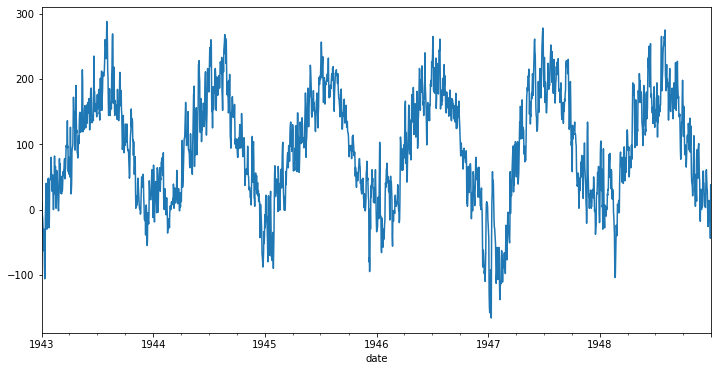

In [13]:
df['1943':'1948']['tgnew'].plot()

In [14]:
df.drop(['tg'], axis=1, inplace=True)

In [15]:
df.rename(columns = {'tgnew':'tg'}, inplace=True)

In [16]:
df.head()

,qtg,year,month,week,day,tg
date,,,,,,
1876-01-01,0,1876,1,52,1,22.0
1876-01-02,0,1876,1,52,2,25.0
1876-01-03,0,1876,1,1,3,3.0
1876-01-04,0,1876,1,1,4,-58.0
1876-01-05,0,1876,1,1,5,-98.0


In [17]:
df['tg'] = df['tg']*0.1

In [18]:
def celsius_to_k(temp):
    return (temp + 273.15)

In [19]:
def k_to_c(temp):
    return temp-273.15

In [20]:
df['tk'] = celsius_to_k(df['tg'])

In [21]:
#Split data into train and test set:
ytrain, ytest = df[:'2018'].copy(), df['2019':].copy() 

In [22]:

def create_timestep(df, deg):
    df['timestep^'+str(deg)] = np.arange(1, len(df)+1)**deg
    return df

# Create a timestep variable
create_timestep(ytrain, 1)
create_timestep(ytrain,2) 

ytrain.head()

,qtg,year,month,week,day,tg,tk,timestep^1,timestep^2
date,,,,,,,,,
1876-01-01,0,1876,1,52,1,2.2,275.35,1,1
1876-01-02,0,1876,1,52,2,2.5,275.65,2,4
1876-01-03,0,1876,1,1,3,0.3,273.45,3,9
1876-01-04,0,1876,1,1,4,-5.8,267.35,4,16
1876-01-05,0,1876,1,1,5,-9.8,263.35,5,25


In [23]:
# fit the model
X = add_constant(ytrain['timestep^1'])
X_sq = add_constant(ytrain[['timestep^1', 'timestep^2']])


In [24]:
y=ytrain['tk']

In [25]:
# Create a model with the timestep only
m = OLS(y, X) # OLS stands for ordinary least squares and it is a method
# to solve a linear regression
results = m.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     tk   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     183.2
Date:                Thu, 13 Aug 2020   Prob (F-statistic):           1.13e-41
Time:                        17:48:23   Log-Likelihood:            -1.8185e+05
No. Observations:               52230   AIC:                         3.637e+05
Df Residuals:                   52228   BIC:                         3.637e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        281.7199      0.069   4091.463      0.000     281.585     281.855
timestep^1  3.091e-05   2.28e-06     13.536      0.000    2.64e-05    3.54e-05
==============================================================================
Omnibus:                     1902.458   Durbin-Watson:                   0.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              974.125
Skew:                          -0.144   Prob(JB):                    2.96e-212
Kurtosis:                       2.396   Cond. No.                     6.03e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
# Create a model with the squared timestep
m_sq = OLS(y, X_sq)
results_sq = m_sq.fit()
results_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     tk   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     124.0
Date:                Thu, 13 Aug 2020   Prob (F-statistic):           1.89e-54
Time:                        17:48:27   Log-Likelihood:            -1.8182e+05
No. Observations:               52230   AIC:                         3.636e+05
Df Residuals:                   52227   BIC:                         3.637e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        282.3380      0.103   2735.225      0.000     282.136     282.540
timestep^1  -4.01e-05   9.13e-06     -4.393      0.000    -5.8e-05   -2.22e-05
timestep^2   1.36e-09   1.69e-10      8.034      0.000    1.03e-09    1.69e-09
==============================================================================
Omnibus:                     1943.803   Durbin-Watson:                   0.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              985.312
Skew:                          -0.144   Prob(JB):                    1.10e-214
Kurtosis:                       2.391   Cond. No.                     3.66e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.66e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We will take the trend to be linear and take only first order differences

In [27]:
# Create a column with the differences of passengers
ytrain['temp_difference'] = ytrain['tk'].diff()
ytrain.head()

,qtg,year,month,week,day,tg,tk,timestep^1,timestep^2,temp_difference
date,,,,,,,,,,
1876-01-01,0,1876,1,52,1,2.2,275.35,1,1,NaN
1876-01-02,0,1876,1,52,2,2.5,275.65,2,4,0.3
1876-01-03,0,1876,1,1,3,0.3,273.45,3,9,-2.2
1876-01-04,0,1876,1,1,4,-5.8,267.35,4,16,-6.1
1876-01-05,0,1876,1,1,5,-9.8,263.35,5,25,-4.0


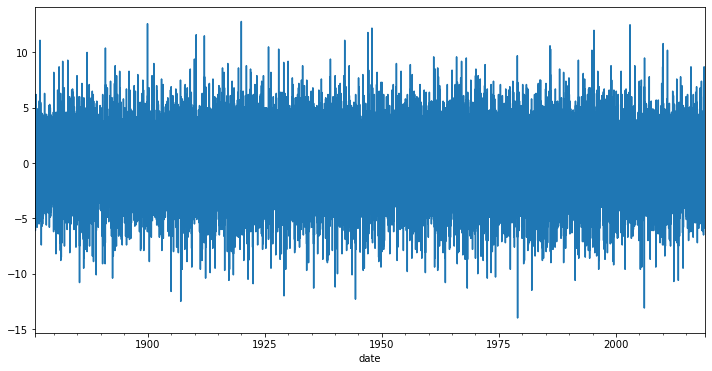

In [29]:
# Plot the result
ytrain['temp_difference'].plot()

In [30]:
# Create a column with the percentage change of passenger numbers
ytrain['percentage_change'] = ytrain['tk'].pct_change()
ytrain.head()

,qtg,year,month,week,day,tg,tk,timestep^1,timestep^2,temp_difference,percentage_change
date,,,,,,,,,,,
1876-01-01,0,1876,1,52,1,2.2,275.35,1,1,NaN,NaN
1876-01-02,0,1876,1,52,2,2.5,275.65,2,4,0.3,0.001090
1876-01-03,0,1876,1,1,3,0.3,273.45,3,9,-2.2,-0.007981
1876-01-04,0,1876,1,1,4,-5.8,267.35,4,16,-6.1,-0.022308
1876-01-05,0,1876,1,1,5,-9.8,263.35,5,25,-4.0,-0.014962


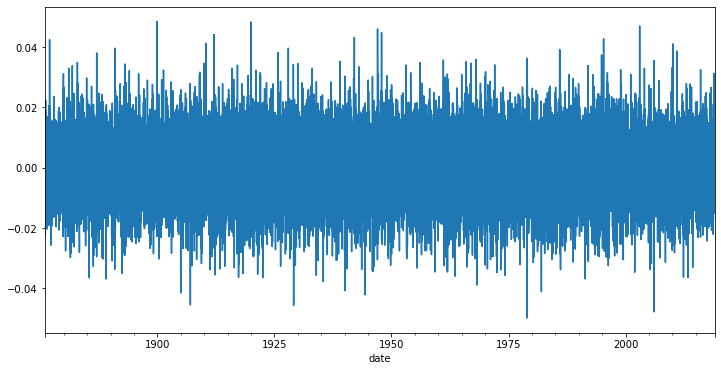

In [31]:
# Plot the result
ytrain['percentage_change'].plot()

In [35]:
# Calculate the monthly mean percentage change of temperature
y_monthly_pct_change = ytrain.groupby('month')['percentage_change']

In [41]:
y_ch = pd.DataFrame(y_monthly_pct_change.mean())
y_ch

,percentage_change
month,
1,0.000028
2,0.000331
3,0.000561
4,0.000582
5,0.000598
6,0.000261
7,0.000162
8,-0.000286
9,-0.000468


In [34]:
# Create a new column
ytrain['monthly_mean'] = ytrain.groupby('month')['percentage_change'].transform('mean')
ytrain.head()

,qtg,year,month,week,day,tg,tk,timestep^1,timestep^2,temp_difference,percentage_change,monthly_mean
date,,,,,,,,,,,,
1876-01-01,0,1876,1,52,1,2.2,275.35,1,1,NaN,NaN,0.000028
1876-01-02,0,1876,1,52,2,2.5,275.65,2,4,0.3,0.001090,0.000028
1876-01-03,0,1876,1,1,3,0.3,273.45,3,9,-2.2,-0.007981,0.000028
1876-01-04,0,1876,1,1,4,-5.8,267.35,4,16,-6.1,-0.022308,0.000028
1876-01-05,0,1876,1,1,5,-9.8,263.35,5,25,-4.0,-0.014962,0.000028


In [38]:
len(ytest)

547

In [39]:
ytest.head()

,qtg,year,month,week,day,tg,tk
date,,,,,,,
2019-01-01,0,2019,1,1,1,6.6,279.75
2019-01-02,0,2019,1,1,2,1.8,274.95
2019-01-03,0,2019,1,1,3,-0.3,272.85
2019-01-04,0,2019,1,1,4,2.1,275.25
2019-01-05,0,2019,1,1,5,6.1,279.25


In [189]:
# Demean the percentage change
ytrain['deseasonalized'] = ytrain['percentage_change'] - ytrain['monthly_mean']
ytrain.head()

,qtg,year,month,week,day,tg,tg_k,tk,timestep^1,timestep^2,temp_difference,percentage_change,monthly_mean,deseasonalized
date,,,,,,,,,,,,,,
1876-01-01,0,1876,1,52,1,2.2,295.15,275.35,1,1,NaN,NaN,0.000028,NaN
1876-01-02,0,1876,1,52,2,2.5,298.15,275.65,2,4,0.3,0.001090,0.000028,0.001062
1876-01-03,0,1876,1,1,3,0.3,276.15,273.45,3,9,-2.2,-0.007981,0.000028,-0.008009
1876-01-04,0,1876,1,1,4,-5.8,215.15,267.35,4,16,-6.1,-0.022308,0.000028,-0.022335
1876-01-05,0,1876,1,1,5,-9.8,175.15,263.35,5,25,-4.0,-0.014962,0.000028,-0.014989


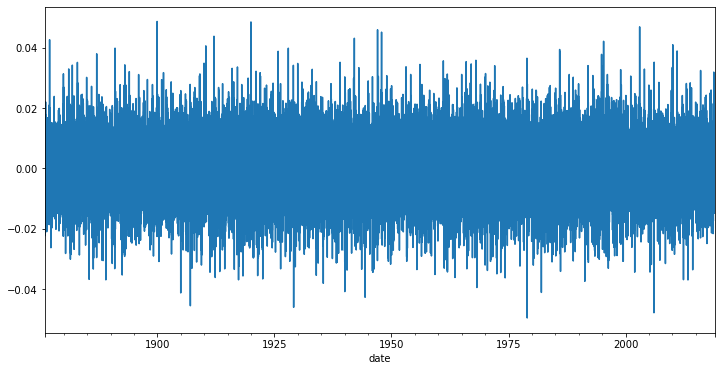

In [190]:
# Plot the result
ytrain['deseasonalized'].plot()

Now we apply naive forecast to the deseasonalised data:

In [191]:
ytrain['tk'].mean()

282.52703905801354

In [204]:
ytest['ypred_mean_k'] = ytrain['tk'].mean()
ytest['ypred_mean_c'] = k_to_c(ytrain['tk'].mean())

In [200]:
# Define a function that plots the forecast for us
def plot_forecast(ytrain, ytest, columns, year):
    '''
    Plots forecasts of passenger data
    
    Params:
    -------
    y_train: The training data
    y_test: The test data
    columns: Name of the prediction columns form a DataFrame
    
    '''
    # Plot the actual values
    ytrain[year:].tg.plot(label='Training Data')
    ytest.tg.plot(label=('Test Data'))
    
    # Plot each prediction
    for column in columns:
        ytest[column].plot(label=column)
    
    # General settings
    plt.title('Temperature over Time', fontsize=15)
    plt.ylabel('Temperature', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend()
    # plt.savefig('mean_baseline.png')
    plt.show()

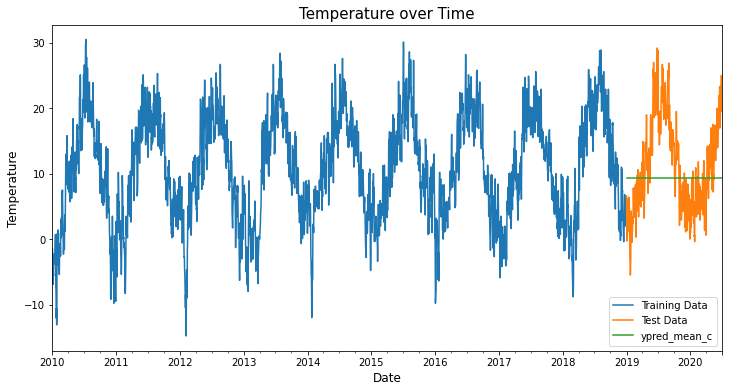

In [205]:
# Plot the forecast
plot_forecast(ytrain, ytest, ['ypred_mean_c'], '2010')

In [206]:
ytrain['percentage_change'].mean()

3.5912148006566554e-05

In [210]:
ytest['y_pred_mean_pct_change_k'] = ytrain['percentage_change'].mean()+1
ytest.tail()

,qtg,year,month,week,day,tg,tg_k,tk,ypred_mean,y_pred_mean_pct_change,ypred_mean_k,ypred_mean_c,y_pred_mean_pct_change_k
date,,,,,,,,,,,,,
2020-06-26,0,2020,6,26,26,22.6,499.15,295.75,9.377039,0.000036,282.527039,9.377039,1.000036
2020-06-27,0,2020,6,26,27,25.0,523.15,298.15,9.377039,0.000036,282.527039,9.377039,1.000036
2020-06-28,0,2020,6,26,28,22.4,497.15,295.55,9.377039,0.000036,282.527039,9.377039,1.000036
2020-06-29,0,2020,6,27,29,19.6,469.15,292.75,9.377039,0.000036,282.527039,9.377039,1.000036
2020-06-30,0,2020,6,27,30,19.8,471.15,292.95,9.377039,0.000036,282.527039,9.377039,1.000036


In [215]:
# Take the cumulative product of the series
ytest['y_pred_mean_pct_change_k'] = np.cumprod(ytest['y_pred_mean_pct_change_k'])
ytest.head()

,qtg,year,month,week,day,tg,tg_k,tk,ypred_mean,y_pred_mean_pct_change,ypred_mean_k,ypred_mean_c,y_pred_mean_pct_change_k
date,,,,,,,,,,,,,
2019-01-01,0,2019,1,1,1,6.6,339.15,279.75,9.377039,3.591215e-05,282.527039,9.377039,1.000036
2019-01-02,0,2019,1,1,2,1.8,291.15,274.95,9.377039,4.631526e-14,282.527039,9.377039,1.000072
2019-01-03,0,2019,1,1,3,-0.3,270.15,272.85,9.377039,2.145104e-27,282.527039,9.377039,1.000108
2019-01-04,0,2019,1,1,4,2.1,294.15,275.25,9.377039,3.567909e-45,282.527039,9.377039,1.000144
2019-01-05,0,2019,1,1,5,6.1,334.15,279.25,9.377039,2.131183e-67,282.527039,9.377039,1.000180


In [217]:
# Take the last actual observation as starting point
last_observation = ytrain['tk'][-1]

In [219]:
ytest['y_pred_mean_pct_change_k'] *= last_observation
ytest.head()

,qtg,year,month,week,day,tg,tg_k,tk,ypred_mean,y_pred_mean_pct_change,ypred_mean_k,ypred_mean_c,y_pred_mean_pct_change_k
date,,,,,,,,,,,,,
2019-01-01,0,2019,1,1,1,6.6,339.15,279.75,9.377039,3.591215e-05,282.527039,9.377039,278.960018
2019-01-02,0,2019,1,1,2,1.8,291.15,274.95,9.377039,4.631526e-14,282.527039,9.377039,278.970036
2019-01-03,0,2019,1,1,3,-0.3,270.15,272.85,9.377039,2.145104e-27,282.527039,9.377039,278.980054
2019-01-04,0,2019,1,1,4,2.1,294.15,275.25,9.377039,3.567909e-45,282.527039,9.377039,278.990073
2019-01-05,0,2019,1,1,5,6.1,334.15,279.25,9.377039,2.131183e-67,282.527039,9.377039,279.000092


In [222]:
ytest['y_pred_mean_pct_change_c']=k_to_c(ytest['y_pred_mean_pct_change_k'])

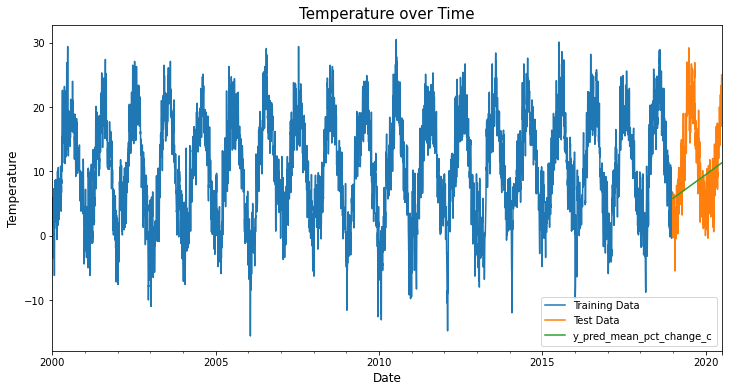

In [224]:
# Plot the forecast
plot_forecast(ytrain, ytest, ['y_pred_mean_pct_change_c'], '2000')

In [227]:
ytrain.columns

Index(['qtg', 'year', 'month', 'week', 'day', 'tg', 'tg_k', 'tk', 'timestep^1',
       'timestep^2', 'temp_difference', 'percentage_change', 'monthly_mean',
       'deseasonalized'],
      dtype='object')

In [236]:
ytest.columns

Index(['qtg', 'year', 'month', 'week', 'day', 'tg', 'tg_k', 'tk', 'ypred_mean',
       'y_pred_mean_pct_change', 'ypred_mean_k', 'ypred_mean_c',
       'y_pred_mean_pct_change_k', 'y_pred_mean_pct_change_c'],
      dtype='object')

In [239]:
ytrain.head()

,qtg,year,month,week,day,tg,tg_k,tk,timestep^1,timestep^2,temp_difference,percentage_change,monthly_mean,deseasonalized
date,,,,,,,,,,,,,,
1876-01-01,0,1876,1,52,1,2.2,295.15,275.35,1,1,NaN,NaN,0.000028,NaN
1876-01-02,0,1876,1,52,2,2.5,298.15,275.65,2,4,0.3,0.001090,0.000028,0.001062
1876-01-03,0,1876,1,1,3,0.3,276.15,273.45,3,9,-2.2,-0.007981,0.000028,-0.008009
1876-01-04,0,1876,1,1,4,-5.8,215.15,267.35,4,16,-6.1,-0.022308,0.000028,-0.022335
1876-01-05,0,1876,1,1,5,-9.8,175.15,263.35,5,25,-4.0,-0.014962,0.000028,-0.014989


In [1]:
ytest

NameError: name 'ytest' is not defined

In [230]:

# Create a new column containing the monthly mean percentage changes
ytest['y_pred_monthly_mean_pct'] = ytrain['monthly_mean'][:12].values
ytest.head()

ValueError: Length of values does not match length of index